<a href="https://colab.research.google.com/github/ArrogantNobody/XAI_based_feature_detector/blob/main/modelT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/USRNet-master")

In [ ]:
import os.path
import cv2
import logging

import numpy as np
from datetime import datetime
from collections import OrderedDict
from scipy.io import loadmat
from scipy import ndimage
import scipy.io as scio
import matplotlib.pyplot as plt


import torch
from torch.nn import ReLU

from utils import utils_deblur
from utils import utils_logger
from utils import utils_sisr as sr
from utils import utils_image as util

from models.network_usrnet import USRNet as net

In [ ]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            # print(grad_in[0].shape)
            self.gradients = grad_in[0]
            #print('grad_in[0].shape', grad_in[0].shape)

        
        first_layer = list(self.model.children())[1].m_head
        print(first_layer)
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            # self.forward_relu_outputs[-1] = None
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        def find_ReLU(model):
          if len(list(model.children())) is 0:
            if isinstance(model, ReLU):
              #print(model)
              model.register_backward_hook(relu_backward_hook_function)
              model.register_forward_hook(relu_forward_hook_function)
              #print(1)
              #return
          for module in model.children():
            find_ReLU(module)
          return

        find_ReLU(self.model)
                

    def generate_gradients(self, img_L,  kernel, sf, sigma):
        # Forward pass
        model_output = self.model(img_L, kernel, sf, sigma)
        # Zero gradients
        self.model.zero_grad()
        #img_L.requires_grad_()
        model_output.backward(img_L)
        # Convert Pytorch variable to numpy array
        #print(self.gradients)
        gradients_as_arr = self.gradients.data.numpy()[0]#.permute(1,2,0)
        return gradients_as_arr

In [ ]:
# ----------------------------------------
# Preparation
# ----------------------------------------

#test_image = 'us.png'    # 'chip.png', 'comic.png'
#test_image = 'us.png'

def usr(test_image):
  model_name = 'usrgan_tiny'      # 'usrgan' | 'usrnet' | 'usrgan_tiny' | 'usrnet_tiny'
  testset_name = 'set_real'  # test set,  'set_real'
  sf = 1                     # scale factor, only from {1, 2, 3, 4}
  show_img = False           # default: False
  save_E = True              # save estimated image
  save_LE = False             # save zoomed LR, Estimated images

  # ----------------------------------------
  # set noise level and kernel
  # ----------------------------------------
  if 'chip' in test_image:
      noise_level_img = 15       # noise level for LR image, 15 for chip
      kernel_width_default_x1234 = [0.6, 0.9, 1.7, 2.2] # Gaussian kernel widths for x1, x2, x3, x4
  else:
      noise_level_img = 2      # noise level for LR image, 0.5~3 for clean images
      kernel_width_default_x1234 = [0.4, 0.7, 1.5, 2.0] # default Gaussian kernel widths of clean/sharp images for x1, x2, x3, x4

  noise_level_model = noise_level_img/255.  # noise level of model
  kernel_width = kernel_width_default_x1234[sf-1]

  # set your own kernel width
  # kernel_width = 2.2

  k = utils_deblur.fspecial('gaussian', 25, kernel_width)
  k = sr.shift_pixel(k, sf)  # shift the kernel
  k /= np.sum(k)
  util.surf(k) if show_img else None
  # scio.savemat('kernel_realapplication.mat', {'kernel':k})

  # load approximated bicubic kernels
  #kernels = hdf5storage.loadmat(os.path.join('kernels', 'kernel_bicubicx234.mat'))['kernels']
  #    kernels = loadmat(os.path.join('kernels', 'kernel_bicubicx234.mat'))['kernels']
  #    kernel = kernels[0, sf-2].astype(np.float64)

  kernel = util.single2tensor4(k[..., np.newaxis])


  n_channels = 1 if 'gray' in  model_name else 3  # 3 for color image, 1 for grayscale image
  model_pool = 'model_zoo'  # fixed
  testsets = 'testsets'     # fixed
  results = 'results'       # fixed
  result_name = testset_name + '_' + model_name
  model_path = os.path.join(model_pool, model_name+'.pth')

  # ----------------------------------------
  # L_path, E_path
  # ----------------------------------------
  L_path = os.path.join(testsets, testset_name) # L_path, fixed, for Low-quality images
  E_path = os.path.join(results, result_name)   # E_path, fixed, for Estimated images
  util.mkdir(E_path)

  logger_name = result_name
  utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
  logger = logging.getLogger(logger_name)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # ----------------------------------------
  # load model
  # ----------------------------------------
  if 'tiny' in model_name:
      model = net(n_iter=6, h_nc=32, in_nc=4, out_nc=3, nc=[16, 32, 64, 64],
                  nb=2, act_mode="R", downsample_mode='strideconv', upsample_mode="convtranspose")
  else:
      model = net(n_iter=8, h_nc=64, in_nc=4, out_nc=3, nc=[64, 128, 256, 512],
                  nb=2, act_mode="R", downsample_mode='strideconv', upsample_mode="convtranspose")

  model.load_state_dict(torch.load(model_path), strict=True)
  model.eval()
  # for key, v in model.named_parameters():
  #     v.requires_grad = False

  number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
  logger.info('Params number: {}'.format(number_parameters))
  model = model.to(device)
  logger.info('Model path: {:s}'.format(model_path))

  logger.info('model_name:{}, image sigma:{}'.format(model_name, noise_level_img))
  logger.info(L_path)

  img = os.path.join(L_path, test_image)
  # ------------------------------------
  # (1) img_L
  # ------------------------------------
  img_name, ext = os.path.splitext(os.path.basename(img))
  img_L = util.imread_uint(img, n_channels=n_channels)
  img_L = util.uint2single(img_L)




  util.imshow(img_L) if show_img else None
  w, h = img_L.shape[:2]
  logger.info('{:>10s}--> ({:>4d}x{:<4d})'.format(img_name+ext, w, h))

  # boundary handling
  boarder = 8     # default setting for kernel size 25x25
  img = cv2.resize(img_L, (sf*h, sf*w), interpolation=cv2.INTER_NEAREST)
  img = utils_deblur.wrap_boundary_liu(img, [int(np.ceil(sf*w/boarder+2)*boarder), int(np.ceil(sf*h/boarder+2)*boarder)])
  img_wrap = sr.downsample_np(img, sf, center=False)
  img_wrap[:w, :h, :] = img_L
  img_L = img_wrap

  util.imshow(util.single2uint(img_L), title='LR image with noise level {}'.format(noise_level_img)) if show_img else None

  img_L = util.single2tensor4(img_L)
  img_L = img_L.to(device)
  print(img_L.shape)

  # # ------------------------------------
  # # (2) img_E
  # # ------------------------------------
  sigma = torch.tensor(noise_level_model).float().view([1, 1, 1, 1])
  [img_L, kernel, sigma] = [el.to(device) for el in [img_L, kernel, sigma]]
  GBP = GuidedBackprop(model)

  guided_grads = GBP.generate_gradients(img_L, kernel, sf, sigma)
  print(guided_grads[0])


  x = np.transpose(guided_grads,(1,2,0))
  print(x.shape)
  print(x.min())
  x=x-x.min()
  print(x.max())

  x0 = x[:,:,0]
  x1 = x[:,:,1]
  x2 = x[:,:,2]
  x3 = x[:,:,3]

  y =  x0+x1+x2+x3
  y = y.astype(np.double)
  fig=plt.figure()

  # plt.title("c3")
  plt.axis('off')
  plt.imshow(y,cmap='gray')
  plt.axis('off')
  #plt.savefig('bone_gradient.png')
  return img_L, y


In [ ]:
from skimage.filters import threshold_otsu
from skimage.feature import BRIEF
from skimage.color import rgb2gray

binary is the feature points  
y    is the overlaped  gradient  
x    is the y shifted to positive

now we have keypoints, next use brief to describe each point

In [ ]:
def kp_descp(lap, ori):
  ori_i = np.transpose(ori[0],(1,2,0))
  thresh = threshold_otsu(lap)
  print(thresh)
  by = lap >= thresh
  #plt.imshow(by)

  points = np.argwhere(by)

  extractor = BRIEF()
  g_ori = rgb2gray(ori_i).astype('double')
  extractor.extract(g_ori, points)
  descriptors1 = extractor.descriptors
  print(np.unique(descriptors1,axis=0).shape)
  return ori_i, points, descriptors1

LogHandlers setup!


21-02-15 03:48:20.644 : Params number: 590332
21-02-15 03:48:21.008 : Model path: model_zoo/usrgan_tiny.pth
21-02-15 03:48:21.009 : model_name:usrgan_tiny, image sigma:2
21-02-15 03:48:21.011 : testsets/set_real
21-02-15 03:48:21.594 :    188.png--> ( 180x180 )


torch.Size([1, 3, 200, 200])
Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


/content/drive/My Drive/USRNet-master/models/network_usrnet.py:148: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  otf = torch.rfft(otf, 2, onesided=False)
/content/drive/My Drive/USRNet-master/models/network_usrnet.py:273: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  Xest = torch.irfft(FX, 2, onesided=False)
21-02-15 03:48:25.569 : Params number: 590332
21-02-15 03:48:25.572 : Model path: model_zoo/usrgan_tiny.pth
21-02-15 03:48:25.577 : model_name:usrgan_tiny, image sigma:2
21-02-15 03:48

[[ 1.4781783e-12  3.0623598e-12 -6.9375968e-12 ...  2.4750791e-13
  -3.9918123e-13 -3.3460707e-13]
 [ 4.6836914e-12  3.0660420e-12 -5.5205623e-12 ... -7.2541203e-14
  -6.7774359e-14 -4.6508113e-14]
 [-7.1985170e-13 -1.1753624e-13 -2.4194245e-12 ... -2.9736944e-13
  -5.8361801e-13  4.4371275e-13]
 ...
 [ 4.5099634e-13  2.7949355e-13  5.1736830e-14 ... -7.6591660e-14
   2.2630010e-13 -1.3899076e-13]
 [ 3.4616597e-13  7.6049844e-14 -7.9654667e-14 ... -3.9061473e-14
  -6.2850457e-13 -6.4225101e-14]
 [ 2.9555015e-13  3.7642358e-13  9.6381928e-14 ... -1.7654376e-14
   1.0119107e-13  4.5124023e-14]]
(200, 200, 4)
-1.436455e-09
2.9214808e-09
6.17701510861185e-09
(2069, 256)
LogHandlers exists!


21-02-15 03:48:25.798 :    184.png--> ( 180x180 )


torch.Size([1, 3, 200, 200])
Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
[[ 1.4781783e-12  3.0623598e-12 -6.9375968e-12 ...  2.4750791e-13
  -3.9918123e-13 -3.3460707e-13]
 [ 4.6836914e-12  3.0660420e-12 -5.5205623e-12 ... -7.2541203e-14
  -6.7774359e-14 -4.6508113e-14]
 [-7.1985170e-13 -1.1753624e-13 -2.4194245e-12 ... -2.9736944e-13
  -5.8361801e-13  4.4371275e-13]
 ...
 [ 4.5099634e-13  2.7949355e-13  5.1736830e-14 ... -7.6591660e-14
   2.2630010e-13 -1.3899076e-13]
 [ 3.4616597e-13  7.6049844e-14 -7.9654667e-14 ... -3.9061473e-14
  -6.2850457e-13 -6.4225101e-14]
 [ 2.9555015e-13  3.7642358e-13  9.6381928e-14 ... -1.7654376e-14
   1.0119107e-13  4.5124023e-14]]
(200, 200, 4)
-1.436455e-09
2.9214808e-09
6.17701510861185e-09
(2069, 256)


(0.0, 400.0, 200.0, 0.0)

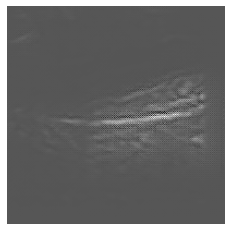

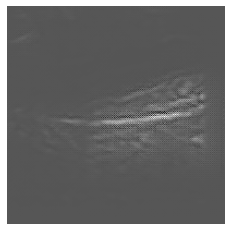

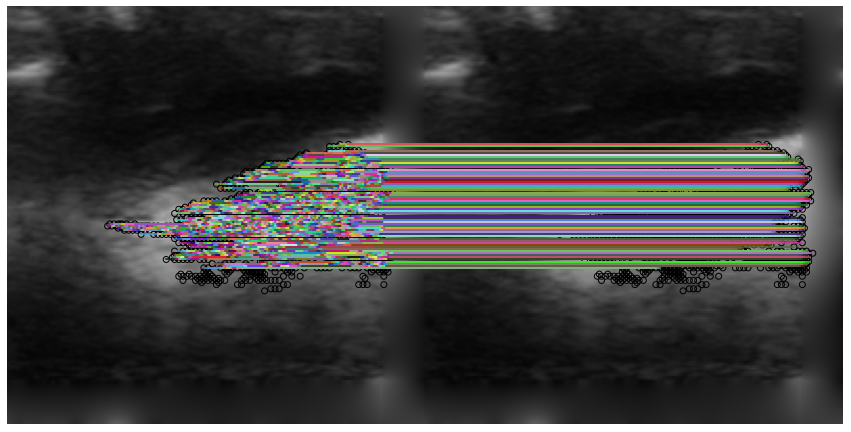

In [ ]:
ori_1, y_1 = usr('188.png')
i1, kp1, des1 = kp_descp(y_1, ori_1)


ori_2, y_2 = usr('184.png')
i2, kp2, des2 = kp_descp(y_2, ori_2)

#pairs
#291-331
#188-184
#157-165


from skimage.feature import match_descriptors

# Match descriptors between images
matches01 = match_descriptors(des1,des2 , cross_check=True)

from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, i1, i2, kp1, kp2, matches01)
ax.axis('off')




(0.0, 400.0, 200.0, 0.0)

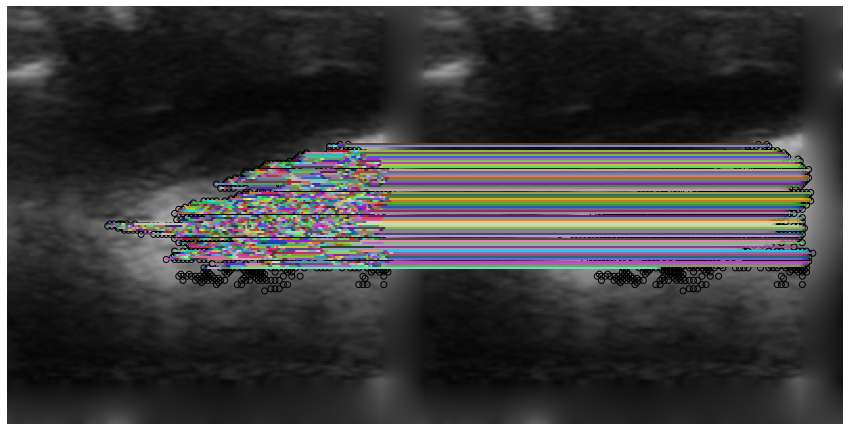

In [ ]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano1
#   * target (reference image): pano0
src = kp2[matches01[:, 1]][:, ::-1]
dst = kp1[matches01[:, 0]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=200, residual_threshold=0.05, max_trials=10000)
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, i1, i2, kp1, kp2, matches01)
ax.axis('off')